##64x64

Будем использовать датасет Petfaces

In [1]:
!wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

--2023-05-30 13:52:22--  http://www.soshnikov.com/permanent/data/petfaces.tar.gz
Resolving www.soshnikov.com (www.soshnikov.com)... 79.137.227.122
Connecting to www.soshnikov.com (www.soshnikov.com)|79.137.227.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-tar]
Saving to: ‘petfaces.tar.gz’

petfaces.tar.gz     100%[===================>]  23.35M   232KB/s    in 1m 42s  

2023-05-30 13:54:05 (233 KB/s) - ‘petfaces.tar.gz’ saved [24483412/24483412]



In [2]:
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.models import Model
from keras.optimizers import Adam

from matplotlib import pyplot as plt
import numpy as np

import os

Создадим датасет встроенной утилитой с размером изображений 64x64

In [3]:
train_images = tf.keras.utils.image_dataset_from_directory(
    'petfaces', label_mode=None, image_size=(64, 64), batch_size=32
)

Found 3211 files belonging to 1 classes.


Посмотрим на сжатое изображение

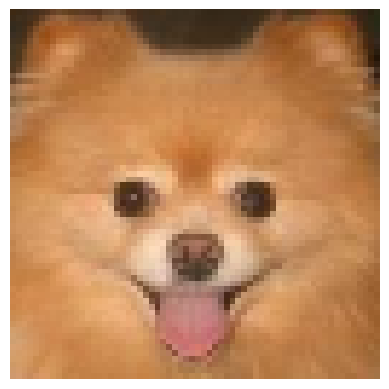

In [25]:
image_batch = next(iter(train_images))
random_index = np.random.choice(image_batch.shape[0])
random_image = image_batch[random_index].numpy().astype("int32")
plt.axis("off")
plt.imshow(random_image)
plt.show()

Преобразуем с диапазону [-1, 1]

In [4]:
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

In [5]:
# размерность гауссовского вектора, чем больше, тем более разнообразные изображения получатся
LATENT_DIM = 100
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# 3 канала цветности
CHANNELS = 3

Генератор создаёт фейковые изображения из случайного распределения (шума). Плотный слой сначала меняет свою форму, чтобы стать многомерным, после этого свёрточные слои сжимают изображение до необходимого размера. На выходе получается тензор изображения со стороный 64 3-х каналов цветности.

In [6]:
def build_generator():
    model = Sequential(name='generator')
 
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    model.add(layers.ReLU())

    # 1D -> 3D
    model.add(layers.Reshape((8, 8, 512)))

    # 16x16
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add((layers.ReLU()))

    # 32x32
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add((layers.ReLU()))

    # 64x64
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add((layers.ReLU()))

    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    return model

In [7]:
generator = build_generator() 
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 128)      524416    
 ranspose)                                               

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Дискриминатору на вход подаётся изображение, которое свёрточными слоями преобразуется к набору фильтров, из которых на полносвязном слое определяется класс - настоящее изображение или сгенерированное. Слой BatchNormalization в любой из сетей делает векторное поле замкнутым.

In [8]:

def build_discriminator(height, width, depth, alpha=0.2):
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    model.add(layers.Conv2D(64, (4, 4), padding="same", strides=(2, 2),
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation="sigmoid"))

    return model

In [9]:
discriminator = build_discriminator(64, 64, 3) 
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

Это класс генеративной нейронной сети. Генератор и дискриминатор "соревнуются", генератор должен "обмануть" дискриминатор. В идеале дискриминатор должен с вероятностью 0,5 определять настоящее изображение или фальшивое. Для этого считаются ошибки. Сначала обновляются веса дискриминатора, а потом генератора.

In [10]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Шаг 1. Обучение дискриминатора на реальных (метка 1) и фейковых изображениях (метка 0) 
        with tf.GradientTape() as tape:
            # Посчитаем ошибку дискриминатора на реальных изображениях
            pred_real = self.discriminator(real_images, training=True)
            real_labels = tf.ones((batch_size, 1))
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels)) 
            d_loss_real = self.loss_fn(real_labels, pred_real)
            # на фейковых
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)
            # общая ошибка дискриминатора
            d_loss = (d_loss_real + d_loss_fake)/2
        # Градиенты дискриминатора
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Обновление весов дискриминатора
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Шаг 2. Обучение генератора
        # Выдаём изображения за настоящие
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

Генерация изображения

In [11]:
def show(model):
    num_img = 16
    latent_dim = 100
    # создание шума для генерации
    seed = tf.random.normal([16, latent_dim])
    generated_images = model.generator(seed)
    generated_images = (generated_images * 127.5) + 127.5
    generated_images.numpy()

    fig = plt.figure(figsize=(4, 4))
    for i in range(num_img):
        plt.subplot(4, 4, i+1)
        img = keras.utils.array_to_img(generated_images[i]) 
        plt.imshow(img)
        plt.axis('off')
    plt.show()

Инициализируем и компилируем модель

In [12]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

Скорость обучения подбирается, чтобы генератор не опережал дискриминатор или наоборот

In [13]:
D_LR = 0.0001
G_LR = 0.0003

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [14]:
NUM_EPOCHS = 155
gan.fit(train_images, epochs=NUM_EPOCHS)

Epoch 1/155
101/101 [==============================] - 23s 72ms/step - d_loss: 2.8935 - g_loss: 0.2120
Epoch 2/155
101/101 [==============================] - 7s 68ms/step - d_loss: 1.7990 - g_loss: 1.1750
Epoch 3/155
101/101 [==============================] - 7s 67ms/step - d_loss: 0.6661 - g_loss: 2.1030
Epoch 4/155
101/101 [==============================] - 7s 66ms/step - d_loss: 0.1753 - g_loss: 2.6935
Epoch 5/155
101/101 [==============================] - 7s 68ms/step - d_loss: 0.0696 - g_loss: 3.0490
Epoch 6/155
101/101 [==============================] - 7s 66ms/step - d_loss: 0.0090 - g_loss: 3.4293
Epoch 7/155
101/101 [==============================] - 7s 67ms/step - d_loss: -0.0284 - g_loss: 3.7593
Epoch 8/155
101/101 [==============================] - 7s 69ms/step - d_loss: -0.0543 - g_loss: 4.1482
Epoch 9/155
101/101 [==============================] - 7s 67ms/step - d_loss: -0.0723 - g_loss: 4.2639
Epoch 10/155
101/101 [==============================] - 7s 66ms/step - d_loss:

Пока обе метрики снижаются, можно ещё обучать

In [15]:
NUM_EPOCHS = 50 # number of epochs
gan.fit(train_images, epochs=NUM_EPOCHS)

Epoch 1/50
101/101 [==============================] - 7s 63ms/step - d_loss: 0.6972 - g_loss: 0.7295
Epoch 2/50
101/101 [==============================] - 7s 64ms/step - d_loss: 0.6946 - g_loss: 0.7356
Epoch 3/50
101/101 [==============================] - 6s 60ms/step - d_loss: 0.6951 - g_loss: 0.7429
Epoch 4/50
101/101 [==============================] - 6s 64ms/step - d_loss: 0.6928 - g_loss: 0.7374
Epoch 5/50
101/101 [==============================] - 6s 61ms/step - d_loss: 0.6940 - g_loss: 0.7383
Epoch 6/50
101/101 [==============================] - 7s 64ms/step - d_loss: 0.6972 - g_loss: 0.7306
Epoch 7/50
101/101 [==============================] - 6s 61ms/step - d_loss: 0.6934 - g_loss: 0.7328
Epoch 8/50
101/101 [==============================] - 6s 64ms/step - d_loss: 0.6948 - g_loss: 0.7406
Epoch 9/50
101/101 [==============================] - 6s 62ms/step - d_loss: 0.6969 - g_loss: 0.7300
Epoch 10/50
101/101 [==============================] - 7s 65ms/step - d_loss: 0.6938 - g_lo

Здесь уже выросла ошибка генератора, посмотрим на результат

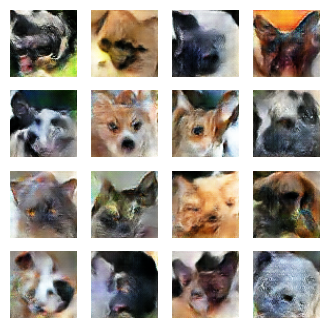

In [ ]:
show(gan)

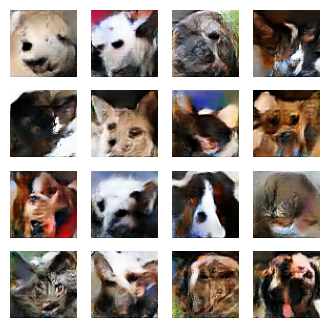

In [17]:
show(gan)

Видны полностью морды на некоторых картинках, но фотографии как будто смазали. Тем не менее, можно сказать, что это испорченные фотографии именно животных.

##128x128

Для большего размера добавим свёрточный слой в конец.

In [22]:
def build_generator():
    model = Sequential(name='generator')
  
    model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
    model.add(layers.ReLU())

    # 1D -> 3D
    model.add(layers.Reshape((8, 8, 512)))

    # 16x16
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add((layers.ReLU()))

    # 32x32
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add((layers.ReLU()))

    # 64x64
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add((layers.ReLU()))

    # 128x128
    model.add(layers.Conv2DTranspose(32, (4, 4), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add((layers.ReLU()))

    model.add(layers.Conv2D(CHANNELS, (4, 4), padding="same", activation="tanh"))

    return model

In [23]:
generator = build_generator() 
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32768)             3309568   
                                                                 
 re_lu_4 (ReLU)              (None, 32768)             0         
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 256)      2097408   
 ranspose)                                                       
                                                                 
 re_lu_5 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 128)      524416    
 ranspose)                                               

А в дискриминатор добывим свёрточный слой в начало.

In [24]:

def build_discriminator(height, width, depth, alpha=0.2):
    # create a Keras Sequential model
    model = Sequential(name='discriminator')
    input_shape = (height, width, depth)

    model.add(layers.Conv2D(32, (4, 4), padding="same", strides=(2, 2),
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Conv2D(64, (4, 4), padding="same", strides=(2, 2),
        input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Conv2D(128, (4, 4), padding="same", strides=(2, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation="sigmoid"))

    return model

In [25]:
discriminator = build_discriminator(128, 128, 3) 
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        1568      
                                                                 
 batch_normalization_3 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        32832     
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)      

In [26]:
train_images = tf.keras.utils.image_dataset_from_directory(
    'petfaces', label_mode=None, image_size=(128, 128), batch_size=32
)
train_images = train_images.map(lambda x: (x - 127.5) / 127.5)

Found 3211 files belonging to 1 classes.


Чуть-чуть увеличили скорость обучения генератора

In [27]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)
D_LR = 0.0001
G_LR = 0.00035
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=D_LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=G_LR, beta_1 = 0.5),  
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [29]:
NUM_EPOCHS = 150 # number of epochs
gan.fit(train_images, epochs=NUM_EPOCHS)

Epoch 1/150
101/101 [==============================] - 18s 109ms/step - d_loss: 3.3331 - g_loss: 0.1135
Epoch 2/150
101/101 [==============================] - 11s 103ms/step - d_loss: 2.9073 - g_loss: 0.4461
Epoch 3/150
101/101 [==============================] - 11s 106ms/step - d_loss: 1.6993 - g_loss: 0.9095
Epoch 4/150
101/101 [==============================] - 11s 108ms/step - d_loss: 0.7711 - g_loss: 1.4529
Epoch 5/150
101/101 [==============================] - 11s 107ms/step - d_loss: 0.3163 - g_loss: 2.0617
Epoch 6/150
101/101 [==============================] - 11s 105ms/step - d_loss: 0.1657 - g_loss: 2.4290
Epoch 7/150
101/101 [==============================] - 11s 105ms/step - d_loss: 0.0956 - g_loss: 2.6680
Epoch 8/150
101/101 [==============================] - 11s 108ms/step - d_loss: 0.0576 - g_loss: 2.9405
Epoch 9/150
101/101 [==============================] - 11s 104ms/step - d_loss: 0.0132 - g_loss: 3.3119
Epoch 10/150
101/101 [==============================] - 11s 106m

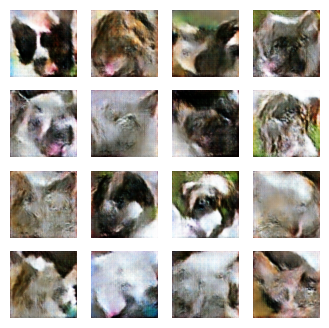

In [ ]:
show(gan)

На большем размере чуть похуже изображения, дальеш увеличивать размер с такой моделью смысла нет.

Для такого плохого результата есть несколько объяснений:  
>Фотографии не были разделены на кошек и собак, из-за чего должны были получиться гибриды, но фотографий собак было больше, поэтому они чаще создавались  
>>Всё ещё не очень хорошо подобрана сокрость обучения, после 150 эпох разтёт ошибка генератора
>>>Возможно, после ещё нескольких сотен эпох генератор и дискриминатор бы выровнялись, а изображения стали бы не такими смазанными